In [2]:
!pip install -q tokenizers
!pip install -q transformers

     |████████████████████████████████| 6.5 MB 7.0 MB/s 
     |████████████████████████████████| 4.0 MB 8.3 MB/s 
     |████████████████████████████████| 596 kB 53.4 MB/s 
     |████████████████████████████████| 895 kB 68.4 MB/s 
     |████████████████████████████████| 77 kB 8.9 MB/s 


#I. Обучение языковой модели

In [9]:
import pandas as pd
import numpy as np
import regex as re
import multiprocessing
import os
import tqdm
import random
import torch
import time
from collections import defaultdict
import shutil

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80
plt.style.use('seaborn-pastel')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Загрузка семпла для обучения языковой модели
df_mlm = pd.read_csv('data_for_language_modeling.csv', sep = '\t')

In [ ]:
df_mlm

,item_name
0,Филе Сельдь киперс х\к
1,Ариэль капсулы
2,"Кернер 2,4 мм"
3,Чай Милфорд 12трав травяной 20*2.25г конв.с/я ...
4,"Баллон газовый ""Экос"" всесезонный"
...,...
9995,Мороженое с клубничным вареньем КАФЕ
9996,Петушок черника с цинком и вит С 17г (25шт шоу...
9997,Кабель USB2.0 AM - microB 5P 1.8м Cablexpert C...
9998,500Г МИСТРАЛЬ РИС САМАРКАНД


In [ ]:
#Функция для предобработки текста
def prepare_text(sentence):
    '''general text preparation'''
    text = re.sub(r'\s+', ' ', sentence).strip().lower() # deleting extra spaces and lowering the data
    text = re.sub('[ó]', 'о', text) # replacing 'ó' with 'о'
    text = re.sub('[ё]', 'е', text) # replacing 'ё' with 'е'
    text = re.sub(r'[^а-яa-z ]+', ' ', text) # picking only english and russian text
    text = re.sub(r'\s+', ' ', text).strip().lower()
    return text

In [ ]:
n_of_cpus_available = multiprocessing.cpu_count()
n_of_cpus_available

2

In [ ]:
#Обработка текста с помощью multiprocessing
%%time
pool = multiprocessing.Pool(processes=n_of_cpus_available)
results = pool.map(prepare_text, df_mlm['item_name'])
pool.close()
pool.join()
df_mlm['prepared_items_for_mlm'] = results

CPU times: user 24.9 ms, sys: 26.5 ms, total: 51.3 ms
Wall time: 543 ms


In [ ]:
df_mlm

,item_name,prepared_items_for_mlm
0,Филе Сельдь киперс х\к,филе сельдь киперс х к
1,Ариэль капсулы,ариэль капсулы
2,"Кернер 2,4 мм",кернер мм
3,Чай Милфорд 12трав травяной 20*2.25г конв.с/я ...,чай милфорд трав травяной г конв с я германия
4,"Баллон газовый ""Экос"" всесезонный",баллон газовый экос всесезонный
...,...,...
9995,Мороженое с клубничным вареньем КАФЕ,мороженое с клубничным вареньем кафе
9996,Петушок черника с цинком и вит С 17г (25шт шоу...,петушок черника с цинком и вит с г шт шоу бокс...
9997,Кабель USB2.0 AM - microB 5P 1.8м Cablexpert C...,кабель usb am microb p м cablexpert cc musbds ...
9998,500Г МИСТРАЛЬ РИС САМАРКАНД,г мистраль рис самарканд


In [ ]:
#Предобработка и сохранение обучающей выборки в txt формат для дальнейшего обучения языковой модели
items_for_mlm = df_mlm['prepared_items_for_mlm']
items_for_mlm = items_for_mlm.map(lambda x: x + '\n')

with open('text_data_for_mlm.txt', 'w') as f:
    f.writelines(items_for_mlm[0:].tolist())

In [ ]:
#Обучение и сохранение токенезатора 'WordPiece' - кол-во слов в словаре 30 тыс.
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.normalizers import Lowercase
from tokenizers.pre_tokenizers import Whitespace, Digits, Sequence
from tokenizers.trainers import WordPieceTrainer

tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Sequence([Whitespace(), Digits()])
tokenizer.normalizer = Lowercase()

trainer = WordPieceTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"], vocab_size=30000)

tokenizer.train_from_iterator(df_mlm['prepared_items_for_mlm'].tolist(), trainer)

tokenizer.save('wordpiece_30k.json')

In [3]:
#Загрузка необходимых модулей для обучения языковой модели
from transformers import (DataCollatorForLanguageModeling, DistilBertConfig,
                          DistilBertForMaskedLM, LineByLineTextDataset,
                          PreTrainedTokenizerFast, Trainer, TrainingArguments)

In [4]:
distilbert_config = DistilBertConfig()

In [5]:
distilbert_config

DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

In [6]:
#Кол-во параметров в оригинальном DistilBert
distilbert_config = DistilBertConfig(vocab_size= 30000, n_heads=12, n_layers = 6, dim=768, hidden_dim=3072)
model = DistilBertForMaskedLM(distilbert_config)
sum(p.numel() for p in model.parameters() if p.requires_grad)

66584112

In [12]:
model.save_pretrained('model')

In [14]:
#Размер модели оригинального DistilBert
print('Model size:', os.path.getsize('model/pytorch_model.bin') / 1024 ** 2, 'MB')
shutil.rmtree('model')

Model size: 254.02995204925537 MB


In [15]:
#Кол-во параметров в уменьшенной версии DistilBert
distilbert_config = DistilBertConfig(vocab_size= 30000, n_heads=8, n_layers = 6, dim=512, hidden_dim=2048)

model = DistilBertForMaskedLM(distilbert_config)
sum(p.numel() for p in model.parameters() if p.requires_grad)

34831152

In [16]:
model.save_pretrained('model')

In [17]:
#Размер модели уменьшенной версии DistilBert
print('Model size:', os.path.getsize('model/pytorch_model.bin') / 1024 ** 2, 'MB')
shutil.rmtree('model')

Model size: 132.90202236175537 MB


In [ ]:
#Обучаем и сохраняем уменьшенную версию языковой модели DistilBert
#(большие семплы необходимо обучать больше 12 часов)

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

tokenizer = PreTrainedTokenizerFast(tokenizer_file = 'wordpiece_30k.json')
tokenizer.mask_token = '[MASK]'
tokenizer.pad_token = "[PAD]"
tokenizer.sep_token = "[SEP]"
tokenizer.cls_token = "[CLS]"
tokenizer.unk_token = "[UNK]"

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path='text_data_for_mlm.txt',
    block_size=256) #for large datasetr try 1024

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability = 0.3)

training_args = TrainingArguments(
    output_dir= 'language_models',
    overwrite_output_dir=True,
    num_train_epochs = 14, 
    learning_rate = 5e-5, 
    per_device_train_batch_size= 32,
    logging_steps = 30,
    save_steps=10000,
    warmup_steps = 0,
    save_total_limit=10)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    eval_dataset=None)

trainer.train()
trainer.save_model('language_models/final_model')

***** Running training *****
  Num examples = 10000
  Num Epochs = 14
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 4382


Step,Training Loss
30,10.151100
60,9.746800
90,9.349300
120,9.215200
150,9.010900
180,9.063600
210,8.945800
240,8.969500
270,8.961400
300,8.846000




Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to language_models/final_model
Configuration saved in language_models/final_model/config.json
Model weights saved in language_models/final_model/pytorch_model.bin


#II. Дообучение на размеченных данных

In [ ]:
#Загружаем размеченнные данные с 15-тью различными брендами
dataset = pd.read_csv('train_test_dataset.csv', sep = '\t')
dataset

,item_name,brand
0,БЗМЖ Сыр Хохланд творожный Креметте Профес,hochland
1,"Смесь семян газонных трав Мираторг ""Унив",мираторг
2,Проплан для кошек АФТА КЕР (кастриров. и сте...,purina
3,Чипсы Lays МИКС 80г-90г.. в ассортименте,lay's
4,Сырок Свитлогорье с ванилином 26% творожный 50...,свитлогорье
...,...,...
2995,Winston Compact P us 100's блю,winston
2996,"ДЕСEPT ТВOPOЖНЫЙ (ВБД) ""ЧYДО"" 100Г =",чудо
2997,КОРМ Д/КОТ PROPLAN ЧУВСТВ ПИЩ ИНДЕЙ 400Г,purina
2998,"КОРЕНОВКА Йогурт б/сахара 0,450 (крышка) БЗМЖ",коровка из кореновки


In [ ]:
dataset.brand.value_counts()

hochland                200
мираторг                200
purina                  200
lay's                   200
свитлогорье             200
чудо                    200
останкино               200
фрутоняня               200
яшкино                  200
коровка из кореновки    200
winston                 200
агуша                   200
чистая линия            200
orbit                   200
milka                   200
Name: brand, dtype: int64

In [ ]:
#Разбиваем на train test
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset,
                                test_size=0.3333333,
                                random_state=42, 
                                stratify=dataset.brand.values)

In [ ]:
train['type'] = 'train'
test['type'] = 'test'

dataset = pd.concat([train, test], axis=0)

In [ ]:
dataset

,item_name,brand,type
960,Чипсы Лейс 90гр Рифленые <7273>,lay's,train
1143,сигареты Winston XStyle Вlue,winston,train
2443,ШОКОЛАД МИЛКА МОЛОЧНЫЙ КАРАМЕЛЬ/ЦЕЛЬНЫЙ ФУНДУК...,milka,train
1412,LAYS белые грибы со сметаной,lay's,train
2126,"Молоко Агуша ультрапастер. 925мл. 3,2%",агуша,train
...,...,...,...
2919,Мороженое Пломбир с брусничным джемом 150 гС...,коровка из кореновки,test
337,Милка Баблс молоч. шок. 90г,milka,test
647,"Пломбир ""Свитлогорье"" Три кота асс. 80гр.",свитлогорье,test
1068,"БЗМЖ-Мороженое ""Чистая Линия"" Пломбир ванильн...",чистая линия,test


In [ ]:
#Осуществляем препроцессинг текста
%%time
pool = multiprocessing.Pool(processes = n_of_cpus_available)
results = pool.map(prepare_text, dataset['item_name'])
pool.close()
pool.join()
dataset['prepared_for_finetuning'] = results

CPU times: user 13.9 ms, sys: 67.5 ms, total: 81.5 ms
Wall time: 356 ms


In [ ]:
dataset

,item_name,brand,type,prepared_for_finetuning
960,Чипсы Лейс 90гр Рифленые <7273>,lay's,train,чипсы лейс гр рифленые
1143,сигареты Winston XStyle Вlue,winston,train,сигареты winston xstyle вlue
2443,ШОКОЛАД МИЛКА МОЛОЧНЫЙ КАРАМЕЛЬ/ЦЕЛЬНЫЙ ФУНДУК...,milka,train,шоколад милка молочный карамель цельный фундук г
1412,LAYS белые грибы со сметаной,lay's,train,lays белые грибы со сметаной
2126,"Молоко Агуша ультрапастер. 925мл. 3,2%",агуша,train,молоко агуша ультрапастер мл
...,...,...,...,...
2919,Мороженое Пломбир с брусничным джемом 150 гС...,коровка из кореновки,test,мороженое пломбир с брусничным джемом гстакан ...
337,Милка Баблс молоч. шок. 90г,milka,test,милка баблс молоч шок г
647,"Пломбир ""Свитлогорье"" Три кота асс. 80гр.",свитлогорье,test,пломбир свитлогорье три кота асс гр
1068,"БЗМЖ-Мороженое ""Чистая Линия"" Пломбир ванильн...",чистая линия,test,бзмж мороженое чистая линия пломбир ванильный ...


In [ ]:
#Создание словаря брендов

brand_labels = {}

def encode_cat(x):
    if x not in brand_labels.keys():
        brand_labels[x]=len(brand_labels)
    return brand_labels[x]
dataset['brand'].apply(lambda x: encode_cat(x))

960      0
1143     1
2443     2
1412     0
2126     3
        ..
2919    12
337      2
647     11
1068     5
957     14
Name: brand, Length: 3000, dtype: int64

In [ ]:
len(brand_labels)

15

In [ ]:
brand_labels

{'hochland': 8,
 "lay's": 0,
 'milka': 2,
 'orbit': 13,
 'purina': 6,
 'winston': 1,
 'агуша': 3,
 'коровка из кореновки': 12,
 'мираторг': 10,
 'останкино': 4,
 'свитлогорье': 11,
 'фрутоняня': 14,
 'чистая линия': 5,
 'чудо': 7,
 'яшкино': 9}

In [ ]:
#Разбиваем наши данные на train/test
train = dataset[dataset['type'] == 'train']
test = dataset[dataset['type'] == 'test']

In [ ]:
#Категории для брендов
categories = np.array(list(brand_labels.keys()))

In [ ]:
categories

array(["lay's", 'winston', 'milka', 'агуша', 'останкино', 'чистая линия',
       'purina', 'чудо', 'hochland', 'яшкино', 'мираторг', 'свитлогорье',
       'коровка из кореновки', 'orbit', 'фрутоняня'], dtype='<U20')

In [ ]:
brand_labels['яшкино']

9

In [ ]:
categories[9]

'яшкино'

In [ ]:
#Загрузка библиотек для дообучения модели на downstream task
from transformers import DistilBertForSequenceClassification
from transformers import AdamW

In [ ]:
#Загрузка токенезатора
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_file='wordpiece_30k.json')
tokenizer.mask_token = '[MASK]'
tokenizer.pad_token = "[PAD]"
tokenizer.sep_token = "[SEP]"
tokenizer.cls_token = "[CLS]"
tokenizer.unk_token = "[UNK]"

In [ ]:
#Класс Dataset для загрузки датасета в Pytorch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [brand_labels[label] for label in df['brand']]
        self.texts = [tokenizer.encode_plus(text, max_length=32, pad_to_max_length=True, truncation=True, return_tensors = 'pt', return_token_type_ids=False) for text in df['prepared_for_finetuning']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
#Подготовка датасета для обучения
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

train_, val_ = Dataset(train), Dataset(test)

batch_size = 3

train_dataloader = torch.utils.data.DataLoader(train_, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_, batch_size=64)

In [ ]:
#Загрузки предобученной языковой модели
model = DistilBertForSequenceClassification.from_pretrained('language_models/final_model', num_labels=len(brand_labels))
model.cuda()

loading configuration file language_models/final_model/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 512,
  "dropout": 0.1,
  "hidden_dim": 2048,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 8,
  

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30000, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=512, out_features=512, bias=True)
            (k_lin): Linear(in_features=512, out_features=512, bias=True)
            (v_lin): Linear(in_features=512, out_features=512, bias=True)
            (out_lin): Linear(in_features=512, out_features=512, bias=True)
          )
          (sa_layer_norm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [ ]:
#Парметры и оптимизатор для обучения
no_decay = ['bias', 'LayerNorm.weight']
decay=1e-6
learning_rate = 3e-5
optimizer_grouped_parameters = [
  {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': decay},
  {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-8)  

n_epochs = 8
device = 'cuda'

In [ ]:
train.shape, test.shape

((2000, 4), (1000, 4))

In [ ]:
len(brand_labels)

15

In [ ]:
#Тренировочный цикл

from sklearn.metrics import f1_score
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

model_name = f'brands_pytorch_train_{train.shape[0]}_test_{test.shape[0]}_br_{len(brand_labels)}_lr_{learning_rate}_bs_{batch_size}_epochs_{n_epochs}'

accuracy_scores = [0.99]
f1_scores = [0.99]

history = defaultdict(list)

for i in range(n_epochs):

    t0 = time.time()
    
    loss_sum = 0
    n_batches = 0

    model.train()

    for train_input, train_label in tqdm.tqdm_notebook(train_dataloader):

        optimizer.zero_grad()

        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        # We apply the BERT model. Note that it computes the loss function, so
        # we won't have to compute the loss separately as in the previous examples.
        outputs = model(input_ids = input_id, attention_mask = None, labels=train_label)
        
        # The outputs tuple consists of the loss and the predictions. We'll just use the loss here.
        loss = outputs.loss
        
        loss.backward()
        optimizer.step()
        #scheduler.step()
                    
        loss_sum += loss.item()
        n_batches += 1
                    
        if n_batches % 50 == 0:
            print(f' ({loss_sum/n_batches:.4f})')
                
    train_loss = loss_sum / n_batches
    history['train_loss'].append(train_loss)

    print(f' ({train_loss:.4f})')

    n_correct = 0
    n_valid = test.shape[0]
    loss_sum = 0
    n_batches = 0

    model.eval()
    

    eval_true_labels = []
    eval_prediced_labels = []

    for val_input, val_label in tqdm.tqdm_notebook(val_dataloader):

        val_label = val_label.to(device)
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
      
        
        with torch.no_grad():
          outputs = model(input_ids = input_id, attention_mask = None, labels=val_label)
          loss_batch = outputs.loss
          scores = outputs.logits
          #loss_batch, scores = outputs
            
        loss_sum += loss_batch.item()
        #measure scores
        guesses = scores.argmax(dim=1)
        eval_prediced_labels.extend(list(np.array(guesses.cpu())))
        eval_true_labels.extend(list(np.array(val_label.cpu())))
        n_correct += (guesses == val_label).sum().item()
        n_batches += 1
        
    val_acc = n_correct / n_valid
    val_loss = loss_sum / n_batches
    f1_score_ = f1_score(eval_true_labels, eval_prediced_labels, average = 'weighted')


    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)        
            
    t1 = time.time()
    print()
    print(f'Epoch {i+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, val acc: {val_acc:.4f}, f1_score: {f1_score_:.4f} time = {t1-t0:.4f}')

    if f1_score_ > max(f1_scores):
      print(f'Saving with score: {f1_score_} round: {i + 1}')
      model.save_pretrained(f'{model_name}_{round(f1_score_,6)}_{i+1}')
    accuracy_scores.append(val_acc)
    f1_scores.append(f1_score_)

  0%|          | 0/667 [00:00<?, ?it/s]

 (2.6696)
 (2.5436)
 (2.3836)
 (2.2846)
 (2.1604)
 (2.0398)
 (1.9246)
 (1.8031)
 (1.6925)
 (1.5810)
 (1.4790)
 (1.3892)
 (1.3153)
 (1.2890)


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 1: train loss = 1.2890, val loss = 0.2455, val acc: 0.9660, f1_score: 0.9664 time = 14.2848


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.2135)
 (0.1886)
 (0.1773)
 (0.1710)
 (0.1621)
 (0.1568)
 (0.1567)
 (0.1578)
 (0.1549)
 (0.1466)
 (0.1405)
 (0.1368)
 (0.1319)
 (0.1298)


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 2: train loss = 0.1298, val loss = 0.0727, val acc: 0.9810, f1_score: 0.9810 time = 14.3340


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.0422)
 (0.0363)
 (0.0357)
 (0.0333)
 (0.0328)
 (0.0309)
 (0.0298)
 (0.0293)
 (0.0287)
 (0.0313)
 (0.0306)
 (0.0294)
 (0.0325)
 (0.0327)


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 3: train loss = 0.0327, val loss = 0.0643, val acc: 0.9830, f1_score: 0.9830 time = 14.2870


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.0239)
 (0.0200)
 (0.0206)
 (0.0188)
 (0.0179)
 (0.0168)
 (0.0157)
 (0.0151)
 (0.0157)
 (0.0158)
 (0.0158)
 (0.0152)
 (0.0146)
 (0.0144)


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 4: train loss = 0.0144, val loss = 0.0320, val acc: 0.9890, f1_score: 0.9890 time = 14.2173


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.0066)
 (0.0067)
 (0.0065)
 (0.0062)
 (0.0061)
 (0.0060)
 (0.0060)
 (0.0058)
 (0.0057)
 (0.0056)
 (0.0055)
 (0.0054)
 (0.0052)
 (0.0052)


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 5: train loss = 0.0052, val loss = 0.0272, val acc: 0.9890, f1_score: 0.9890 time = 14.2375


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.0037)
 (0.0037)
 (0.0036)
 (0.0036)
 (0.0035)
 (0.0034)
 (0.0034)
 (0.0033)
 (0.0032)
 (0.0032)
 (0.0031)
 (0.0031)
 (0.0030)
 (0.0030)


  0%|          | 0/16 [00:00<?, ?it/s]

Configuration saved in brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8_0.990998_6/config.json



Epoch 6: train loss = 0.0030, val loss = 0.0247, val acc: 0.9910, f1_score: 0.9910 time = 14.2808
Saving with score: 0.9909983186117861 round: 6


Model weights saved in brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8_0.990998_6/pytorch_model.bin


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.0023)
 (0.0022)
 (0.0021)
 (0.0022)
 (0.0022)
 (0.0022)
 (0.0021)
 (0.0021)
 (0.0021)
 (0.0021)
 (0.0020)
 (0.0020)
 (0.0019)
 (0.0019)


  0%|          | 0/16 [00:00<?, ?it/s]

Configuration saved in brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8_0.992991_7/config.json



Epoch 7: train loss = 0.0019, val loss = 0.0218, val acc: 0.9930, f1_score: 0.9930 time = 14.9718
Saving with score: 0.9929914211524284 round: 7


Model weights saved in brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8_0.992991_7/pytorch_model.bin


  0%|          | 0/667 [00:00<?, ?it/s]

 (0.0013)
 (0.0014)
 (0.0014)
 (0.0014)
 (0.0014)
 (0.0014)
 (0.0014)
 (0.0013)
 (0.0013)
 (0.0013)
 (0.0013)
 (0.0013)
 (0.0013)
 (0.0013)


  0%|          | 0/16 [00:00<?, ?it/s]


Epoch 8: train loss = 0.0013, val loss = 0.0211, val acc: 0.9910, f1_score: 0.9910 time = 16.7836


brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8: Mean: 0.98542, Max: 0.992991


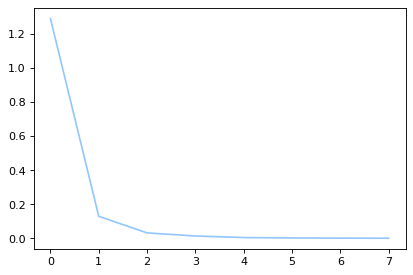

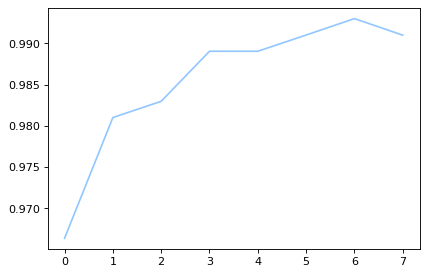

In [ ]:
#График потерь и f1 меры
print(f'{model_name}:', 'Mean:', str(round(np.mean(f1_scores[1:]),6)) + ',', 'Max:', round(max(f1_scores[1:]),6))
plt.plot(history['train_loss'])
plt.show()
plt.plot(f1_scores[1:])
plt.show()

#III. Тестирование обученной модели и inference

In [ ]:
use_gpu = True

if use_gpu:
  device = 'cuda'
else:
  device = 'cpu'

In [ ]:
#Заргрузка лучшей модели
model = DistilBertForSequenceClassification.from_pretrained('brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8_0.992991_7', num_labels=len(brand_labels)).to(device)

loading configuration file brands_pytorch_train_2000_test_1000_br_15_lr_3e-05_bs_3_epochs_8_0.992991_7/config.json
Model config DistilBertConfig {
  "_name_or_path": "language_models/final_model",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 512,
  "dropout": 0.1,
  "hidden_dim": 2048,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL

In [ ]:
#Валидация на тестовой выборке

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

predictions_ = []

for val_input, val_label in tqdm.tqdm_notebook(val_dataloader):
    
    val_label = val_label.to(device)
    mask = val_input['attention_mask'].to(device)
    input_id = val_input['input_ids'].squeeze(1).to(device)
    
    with torch.no_grad():

      outputs = model(input_ids = input_id, attention_mask = None, labels=None)
      scores = outputs.logits

      probs = scores.softmax(1)
      idx_pred = probs.argmax(dim=1).cpu()
      pred = categories[idx_pred]
      predictions_.extend(pred)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
len(predictions_)

1000

In [ ]:
from sklearn.metrics import f1_score
f1_score(list(test.brand), predictions_, average = 'weighted')

0.9929914211524284

In [ ]:
#Функция для single предсказания

def get_prediction(text):

    text = prepare_text(text)

    if text == '':
        pred, pred_proba = 'nobrand', 0.999
        return pred, pred_proba

    with torch.no_grad():
      
      if use_gpu:
        inputs = tokenizer.encode_plus(text, max_length=32, pad_to_max_length=True, truncation=True, return_tensors = 'pt', return_token_type_ids=False).to("cuda")
      else:
        inputs = tokenizer.encode_plus(text, max_length=32, pad_to_max_length=True, truncation=True, return_tensors = 'pt', return_token_type_ids=False)
        
      outputs = model(inputs['input_ids'], attention_mask = None, labels = None)
      
      probs = outputs.logits.softmax(1)

      idx_pred = probs.argmax()

    pred_proba = float(probs.max())
    pred = categories[idx_pred]
    return pred, pred_proba

In [ ]:
text = 'ДП Нектар ФРУТОНЯНЯ 200гр Тыква/мякоть с 4 мес т/п 1/18шт'

In [ ]:
get_prediction(text)

('фрутоняня', 0.9990600943565369)

In [ ]:
#Замеряем скорость работы
%%timeit
get_prediction(text)

100 loops, best of 5: 4.2 ms per loop
